In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os



INIT_LR= 1e-3 #Learning Rate of the model formation
EPOCHS = 20 #We have used 20 epochs for tranfer learning
BS = 32





DIRECTORY = r"C:\Users\IAmPradeep\Downloads\dataset"
CATEGORIES = ["with_mask", "without_mask"]





data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)




#storing the data as numpy arrays
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)




C:\Users\IAmPradeep\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [4]:
# For augmentation of the image
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# Here, We are loading the base model MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224,3)))

In [ ]:


#We have modified the last layer of MobileNetV2  by adding five new layers for fine tuning purposes.
#The newly added layers include Maximum  pooling layer of pool size equal to 7× 7, a flattering layer, 
# a dense ReLU layer which contains  128 neurons, a dropout of 0.5 and a decisive layer with softmax activation 
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("Wait,Now We are training the model...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

# classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
print("[Saving the optimized mask detector model...")
model.save("mask_detector.model", save_format="h5")

Wait,Now We are training the model...
Epoch 1/20
20/20 [==============================] - 18s 828ms/step - loss: 0.3188 - accuracy: 0.8671 - val_loss: 0.0527 - val_accuracy: 1.0000
Epoch 2/20
20/20 [==============================] - 17s 828ms/step - loss: 0.0702 - accuracy: 0.9794 - val_loss: 0.0155 - val_accuracy: 1.0000


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x00000182D5AC0160>
Traceback (most recent call last):
  File "C:\Users\IAmPradeep\anaconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "C:\Users\IAmPradeep\anaconda3\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1262, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


Epoch 3/20
 2/20 [==>...........................] - ETA: 13s - loss: 0.0225 - accuracy: 1.0000

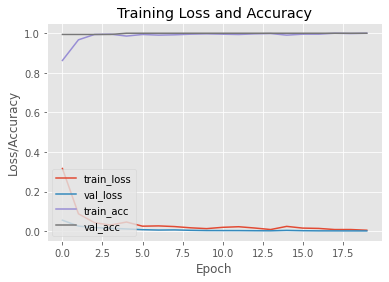

In [5]:
#Function for ploting the image
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [1]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)
	faces = []
	locs = []
	preds = []

	for i in range(0, detections.shape[2]):
		confidence = detections[0, 0, i, 2]
		if confidence > 0.5:
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	if len(faces) > 0:
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)
	return (locs, preds)
prototxtPath = r"C:\Users\IAmPradeep\Downloads\PradeepNatrajan_11932_Sem_V_SummerInternship\deploy.prototxt"
weightsPath = r"C:\Users\IAmPradeep\Downloads\PradeepNatrajan_11932_Sem_V_SummerInternship\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)
maskNet = load_model(r"C:\Users\IAmPradeep\Downloads\PradeepNatrajan_11932_Sem_V_SummerInternship\mask_detector.model")
vs = VideoStream(src=0).start()
while True:
	frame = vs.read()
	frame = imutils.resize(frame, width=400)
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
	for (box, pred) in zip(locs, preds):
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        
		label = "{}: {:.1f}%".format(label, max(mask, withoutMask) * 100)
		cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	cv2.imshow("Real Time Facemask Detection", frame)
    
	if cv2.waitKey(2) == 27:
		break
cv2.destroyAllWindows()
vs.stream.release()

(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200